In [1]:
import os, sys

os.chdir('D:\Downloads\@Books\@TPM\@PDPC\@data_analysis\model_build')
sys.path.append('D:\Downloads\@Books\@TPM\@PDPC\@data_analysis\model_build')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as ticker  ## special scaling stuff
import cmasher as cmr
import colorcet as cet
from importlib import reload  ## for reloading packages
import pickle
import OFM_postprocess_scripts as post
from importlib import reload

In [2]:
# retrieve files from saved pickles
model_vers = 'v4'
exps_batchname = 'ImportScale'
exps_s = post.read_experiments_from_pickle(f'data_output/experiments_{exps_batchname}_model{model_vers}.pickleobject')

ref_batchname = "Reference"
exps_r = post.read_experiments_from_pickle(f'data_output/experiments_{ref_batchname}_model{model_vers}.pickleobject')
# extract relevant information from pickled experiment object
# reload(post)
meta_s = pd.DataFrame.from_dict(exps_s.results_metadata, orient='index')
meta_s['p_FlightBans'] = exps_s.c_nominal_ref_date  # need to explicit add
exps_s.results_postprocess['p_FlightBans'] = exps_s.c_nominal_ref_date
meta_s['p_FlightBans_nom'] = meta_s['p_FlightBans'] - exps_s.c_nominal_ref_date
results_s: pd.DataFrame = post.add_extra_metrics(exps_s)

meta_r = pd.DataFrame.from_dict(exps_r.results_metadata, orient='index')
meta_r['p_FlightBans_nom'] = meta_r['p_FlightBans'] - exps_r.c_nominal_ref_date
results_r: pd.DataFrame = post.add_extra_metrics(exps_r)

# invert the policy inputs to be relative again (instead of machine-focused)
policy_inputs = dict((v, k) for k, v in exps_s.p_flightbans_map.items())  # inversion process
exps_s.results_verbose = exps_s.results_postprocess = None
exps_r.results_verbose = exps_r.results_postprocess = None

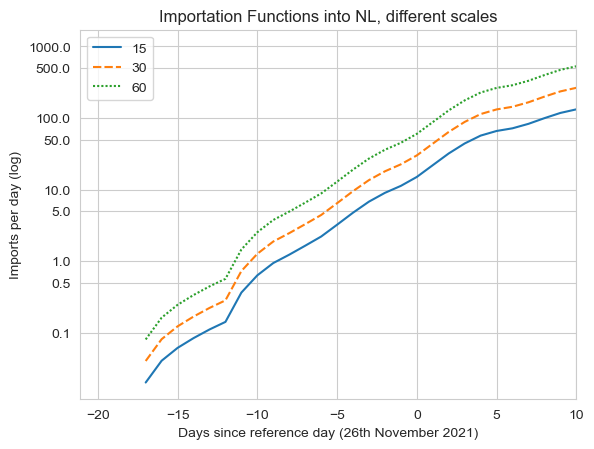

In [23]:
# plot the importation scales on graph
imports_nonflights = exps_s.i_flights_scaled.drop(labels=0, axis=1)
imports_nonflights.index = imports_nonflights.index - exps_s.c_nominal_ref_date
sns.lineplot(imports_nonflights)

plt.title('Importation Functions into NL, different scales')
plt.ylabel('Imports per day')
plt.xlabel('Days since reference day (26th November 2021)')

save_name = 'importation function scaled'
# plt.savefig(f'output_figures/plot_{save_name}_full_linear.jpg', dpi=300)
plt.xlim((None, 10))
# plt.savefig(f'output_figures/plot_{save_name}_zoom_linear.jpg', dpi=300)


plt.yscale('log')
plt.gca().set_yticks(ticks=(0.1,0.5, 1., 5, 10, 50, 100, 500, 1000))
# plt.gca().tick_params(axis='y', which='minor',bottom=True)
ticks_y = ticker.FuncFormatter(lambda x, pos: f'{float(x)}')
plt.gca().yaxis.set_major_formatter(ticks_y)
plt.ylabel('Imports per day (log)')
plt.savefig(f'output_figures/plot_{save_name}_zoom_log.jpg', dpi=300)



In [243]:
metric = 'cum_infected' #
# metric = 'infected_new'
threshold = 50000  # 50k for cumulative, 5k for duration
inf_new_p_piv = results_s.pivot(values='infected_new', index='elapsed_nominal', columns='exp_id')
df_inf_new_p = post.add_threshold_time_search(df_to_search=inf_new_p_piv,
                                              df_to_add=meta_s,
                                              threshold=threshold)
df_inf_new_p['u_ImportsInitial'] = df_inf_new_p['u_ImportsFlights'] + df_inf_new_p['u_ImportsIndirect']

# set up reference case
inf_new_r_piv = results_r.pivot(values='infected_new', index='elapsed_nominal', columns='exp_id')
df_inf_new_r = post.add_threshold_time_search(df_to_search=inf_new_r_piv,
                                              df_to_add=meta_r,
                                              threshold=threshold)
# ensuring equal comparison with the same initial import rate
df_inf_new_r['u_ImportsInitial'] = df_inf_new_r['u_ImportsFlights'] # reference case has no initial import rate

In [244]:
# collect specific values
values = f'start_{threshold}'  # for cumulative 50k
# values = f'duration_{threshold}' # for new daily 5k
# values = 'max'

# note different from Policies, as no policies were added
# inf_new_r_metric = df_inf_new_r.pivot(columns=('p_FlightBans_nom', 'u_ImportsFlights'),
#                                       index=['u_Rzero', 'u_ImportsInitial'],
#                                       values=values)
inf_new_r_metric = df_inf_new_r.loc[df_inf_new_r['p_FlightBans_nom'] == 0, ['u_Rzero','u_ImportsInitial', values]].set_index(['u_Rzero', 'u_ImportsInitial'])
inf_new_p_metric = df_inf_new_p.pivot(columns='u_ImportsIndirect', index=['u_Rzero', 'u_ImportsInitial'], values=values)

In [245]:
# manual operation
# find the same Rzero, and imports initials
# some big black magic applied here # TODO: document what was done
# inf_new_r_metric_reduced = inf_new_r_metric.loc[(df_inf_new_p['u_Rzero'], df_inf_new_p['u_ImportsInitial']), (0, df_inf_new_p['u_ImportsInitial'])].droplevel(axis=1, level=0)

inf_new_p_initial = df_inf_new_p.pivot(columns='u_ImportsIndirect',
                                       index=['u_Rzero', 'u_ImportsFlights'],
                                       values='u_ImportsInitial')
# to_subtract = inf_new_p_metric.applymap(lambda)

In [246]:
# do it the dumb way
dumbway_mk1 = {}
for row in inf_new_p_initial.itertuples():
    r, initial = row.Index

    dumbway_mk1[(r,initial)] = dict(zip(inf_new_p_initial.columns,[inf_new_r_metric.squeeze().loc[(r,elem)] for elem in row[1:]]))
    # for elem in row[1:]:
    #     temp_dict = {}
    #     dumbway_mk1[(r, elem)] = inf_new_r_metric.squeeze().loc[(r, elem)]

    # print(row)

dumbway_df = pd.DataFrame.from_dict(dumbway_mk1, orient='index')
del dumbway_mk1, row, r, initial

In [239]:
inf_new_p_metric_present = df_inf_new_p.pivot(columns='u_ImportsIndirect',
                                              index=['u_Rzero','u_ImportsFlights'],
                                              values=values)

In [247]:
dumbway_df

0    15  30
1.3 0   -17  108  99
    15  108   99  94
    30   99   94  90
    60   90   87  85
1.5 0   -17   65  59
    15   65   59  56
    30   59   56  54
    60   54   52  50
2.0 0   -17   33  30
    15   33   30  28
    30   30   28  27
    60   27   26  25
2.5 0   -17   22  20
    15   22   20  18
    30   20   18  17
    60   17   17  16
3.0 0   -17   16  14
    15   16   14  13
    30   14   13  12
    60   12   12  11

In [240]:
# get difference between metrics and the reference case
pr_deltas = (inf_new_p_metric_present - dumbway_df)

In [241]:
inf_new_p_metric_present

u_ImportsIndirect          0    15   30
u_Rzero u_ImportsFlights               
1.3     0                 500  121  118
        15                122  121  118
        30                123  121  119
        60                123  121  119
1.5     0                 500   88   88
        15                 90   89   87
        30                 89   88   87
        60                 89   88   87
2.0     0                 500   56   56
        15                 57   56   56
        30                 56   56   55
        60                 56   55   56
2.5     0                 500   42   42
        15                 43   42   42
        30                 42   42   42
        60                 42   42   42
3.0     0                 500   34   35
        15                 34   34   35
        30                 34   34   34
        60                 34   35   34

In [235]:
pr_deltas

u_ImportsIndirect          0         15        30
u_Rzero u_ImportsFlights                         
1.3     0                 0.0   2251.67   4505.94
        15                0.0   2247.48   4513.60
        30                0.0   2289.45   4512.93
        60                0.0   2223.67   4534.71
1.5     0                 0.0   2506.62   4731.91
        15                0.0   2309.46   4682.84
        30                0.0   2399.85   4391.26
        60                0.0   2291.01   4842.42
2.0     0                 0.0   2270.55   4537.83
        15                0.0   2671.67   3415.04
        30                0.0   2192.93   5046.10
        60                0.0   2484.25   4441.08
2.5     0                 0.0   2040.96   2566.82
        15                0.0  -3038.75  10707.28
        30                0.0   2444.88   9377.74
        60                0.0   2176.16    455.11
3.0     0                 0.0   3578.14  -3264.57
        15                0.0 -12540.48 -13306.73
        30                0.0  -8258.59   2154.29
        60                0.0  -1637.34   2110.84

In [71]:
# boil down
piv_cumul = results_s.pivot(values='cum_infected', index='elapsed_nominal', columns='exp_id')
threshold = 50000
cumul_stats = post.add_threshold_time_search(df_to_search=piv_cumul,
                                             df_to_add=meta_s,
                                             threshold=threshold)

cumul_stats['scenario_full'] = list(zip(cumul_stats.u_ImportsFlights, cumul_stats.u_ImportsIndirect))

In [72]:
to_sort = ['u_Rzero', 'p_FlightBans_nom', 'u_ImportsFlights', 'u_ImportsIndirect']
cumul_stats['scenario_full'] = cumul_stats[to_sort].apply(tuple, axis=1)
cumul_stats['u_ImportsPreBan'] = cumul_stats[['u_ImportsFlights', 'u_ImportsIndirect']].sum(axis=1)

<AxesSubplot: xlabel='duration_50000', ylabel='max_day'>

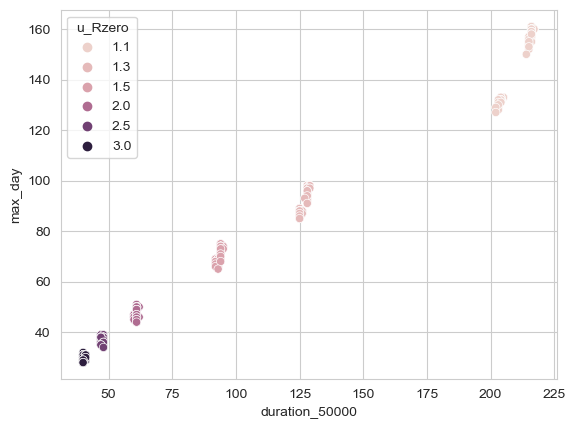

In [21]:
sns.scatterplot(data=cumul_stats,
                y='max_day',
                x='duration_50000',
                hue='u_Rzero')

In [ ]:
# look at scatter deltas?
# vertical and horizontal scatter
# kinda wish we'd make a proper sensitivity analysis now...

In [128]:
to_sort = ['u_Rzero', 'u_ImportsIndirect', 'start_50000', ]  #['u_Rzero', 'p_FlightBans_nom','u_ImportsFlights','u_ImportsIndirect']
cumul_stats_sort = cumul_stats.sort_values(by=to_sort, ascending=(False, False, True))
# cumul_stats_sort['scenario_full'] =  cumul_stats_sort[to_sort].apply(tuple, axis=1) #list(zip(cumul_stats_sort[col] for col in to_sort))

In [129]:
plot_data = cumul_stats_sort.copy()
plot_data['idx'] = plot_data.sort_index().index
plot_data['max'] = plot_data['max'] / exps_s.c_pop_total
plot_data = plot_data.melt(
    value_vars=['u_Rzero', 'u_ImportsIndirect', 'u_ImportsFlights', 'u_ImportsPreBan', 'p_FlightBans_nom', 'max', 'max_day','start_50000',],
    id_vars=['idx'])

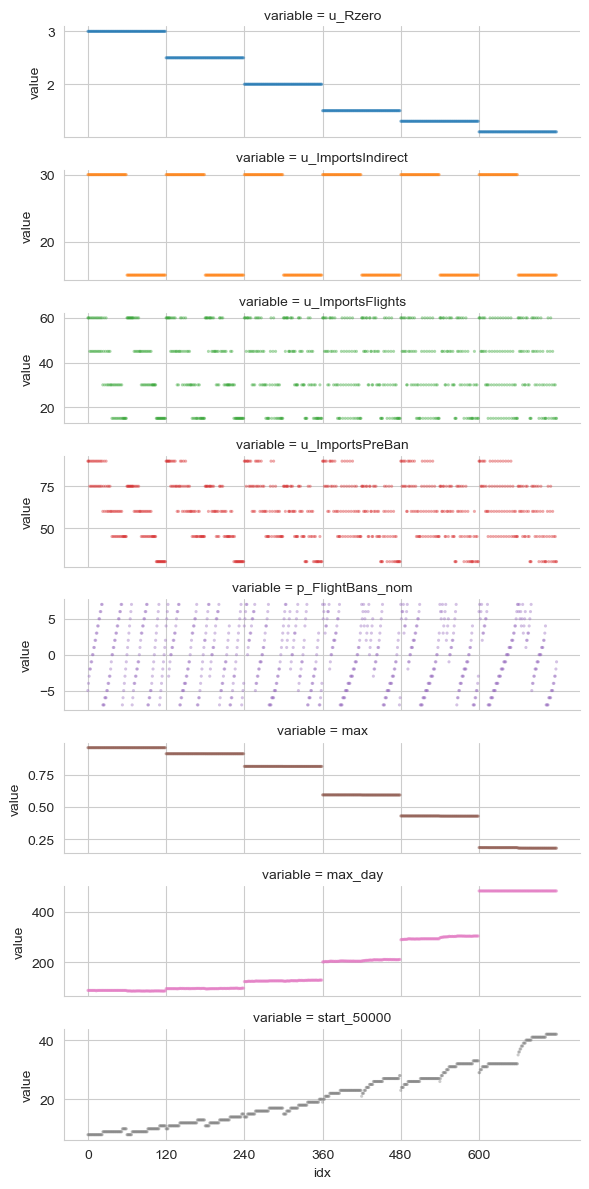

In [130]:
fig = sns.relplot(data=plot_data,
                  x='idx',
                  y='value',
                  row='variable',
                  hue='variable',
                  alpha=0.4,
                  height=1.5,
                  aspect=4,
                  kind='scatter',
                  facet_kws={'sharey': False},
                  linewidth=0,
                  s=5,
                  legend=False,
                  )
plt.xticks(range(0, 701, 120))

plt.savefig(f'output_figures/{model_vers}_{exps_batchname} sens multiplot cumulative 50k (varsort).jpg', dpi=300)
# plt.xlim((None, 300))
# how to show the effect of added importation

In [51]:
# collect indices of importance
# we do single-variate analysis first, with 0-day case?
d0_sens = results_s.loc[results_s.p_FlightBans == policy_inputs[0], :]
# d0_sens['infected_cum_pct'] = d0_sens['cum_infected'] / exps_s.c_pop_total  # TODO move this to function form

In [52]:

# we now isolate only the metric (cumulative infections) and relevant states: day, exp_id, policy/uncertainty
# trim out, mostly for readability
# d0_sens = d0_sens.loc[:, ['exp_id','elapsed_policy','imported','cum_infected', 'infected_total','infected_new']]
# get u_REff from meta
d0_meta = meta_s.loc[meta_s['p_FlightBans'] == policy_inputs[0], ['u_REff', 'u_NominalImports']]

d0_p_imported = d0_sens.pivot(values='imported', index='elapsed_policy', columns='exp_id')
d0_p_inf_cumulative = d0_sens.pivot(values='cum_infected', index='elapsed_policy', columns='exp_id')
d0_p_inf_current = d0_sens.pivot(values='infected_total', index='elapsed_policy', columns='exp_id')
# NB: seaborn prefers long data form for plotting!
# TODO: verify if the u_NominalImports scaling is correct!
# 50k-50k.. how to find?
# top-down search and bottom-up search?
threshold = 5000
d0_m_inf_current = post.add_threshold_time_search(df_to_search=d0_p_inf_current,
                                                  df_to_add=d0_meta,
                                                  threshold=threshold)

# make another m df for cumulative

In [53]:

# d0_mat_duration = d0_m_inf_current.pivot(values=f'duration_{threshold}', index='u_REff', columns='u_NominalImports')
# d0_mat_max = d0_m_inf_current.pivot(values='max', index='u_REff', columns='u_NominalImports')
# d0_mat_maxday = d0_m_inf_current.pivot(values='max_day', index='u_REff', columns='u_NominalImports')
# prolly can plot the max day and duration as a quadrant plot?

# Sensitivity: colour definition

In [54]:
# get categories from the experiment object
s_R_categories = exps_s.PARAMS_RAW['u_REff']
s_R_highlight = [1.1, 1.5, 2.0, 2.5, 3.0]  # hues to highlight
s_R_dull_colour = 'silver'  # hues to keep in background
s_R_ref_colour = {1.3: 'limegreen'}  # specific highlight for reference line (R=1.3)
s_R_highlight_all = sorted(s_R_highlight + [1.3])

# create custom palette for plotting
palette_s = cmr.get_sub_cmap('cmr.guppy_r', start=0., stop=1., N=len(s_R_highlight))  # make colourful palette
palette_s2 = dict((R, s_R_dull_colour) for R in s_R_categories)  # create all R-value categories in dull colours
palette_s2.update(
    dict(zip(s_R_highlight, palette_s.colors)))  #  change the highlighted categories to have bright colours
palette_s2.update(s_R_ref_colour)  # change the colour of the reference line

# Plot : sensitivity analysis, R on total infectious people

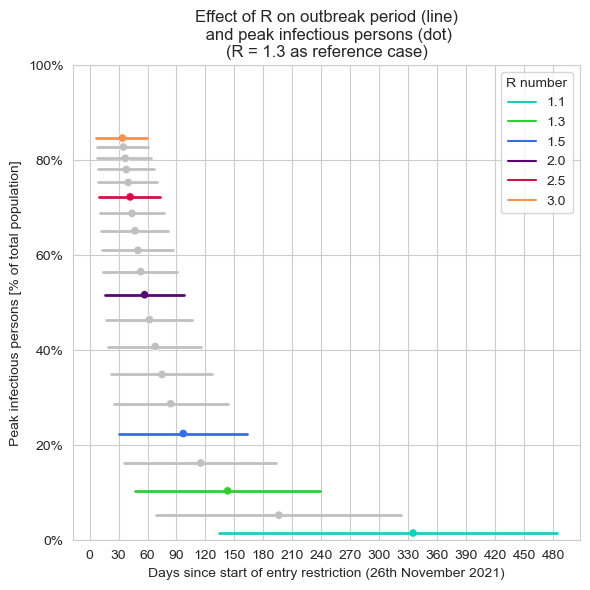

In [55]:
# let's try that map plot
# plot start and end, with central point as max day
# TODO: be careful that some inputs are floats and are not set to categorical form
# TODO: convert scaling to percentage of population?
plot_data = d0_m_inf_current.loc[(d0_m_inf_current['u_REff'] > 1.001) & (d0_m_inf_current['u_NominalImports'] == 15), :]
# ad hoc additions
plot_data = pd.melt(plot_data, id_vars=['u_REff', 'u_NominalImports', 'max_day', 'max'],
                    value_vars=['start_5000', 'end_5000'],
                    value_name='x')
plot_data['max'] = plot_data['max'] / exps_s.c_pop_total
# palette = cmr.get_sub_cmap('cmr.guppy_r', start=0.1, stop=0.9)
fig1, ax1 = plt.subplots(figsize=(6, 6))
plot_data = plot_data.rename(columns={'u_REff': 'R number',
                                      'u_NominalImports': 'Total Imports'},
                             )
plot_duration = sns.lineplot(plot_data, x='x', y='max', ax=ax1, palette=palette_s2,
                             hue='R number',  # style='Total Imports', dashes=dash_styles,
                             linewidth=2.)
plot_peaks = sns.scatterplot(plot_data, x='max_day', y='max', ax=ax1, palette=palette_s2, hue='R number', legend=False)
# rename axis
ax1.set_ylim(0, 1)
ticks_y = ticker.FuncFormatter(lambda x, pos: f'{int(100 * x)}%')  # black magic
ax1.yaxis.set_major_formatter(ticks_y)
# ticks_x = ticker.FuncFormatter(lambda x, pos: f'{x/28}')
# ax1.xaxis.set_major_formatter(ticks_x)
ax1.set_xticks(ticks=range(0, 501, 30))

ax1.set_ylabel('Peak infectious persons [% of total population]')
ax1.set_xlabel('Days since start of entry restriction (26th November 2021)')
ax1.set_title('Effect of R on outbreak period (line)\n '
              'and peak infectious persons (dot)\n'
              '(R = 1.3 as reference case)')

# get legend handles
h, l = ax1.get_legend_handles_labels()
h = [h[k] for k, a in enumerate(l) if float(a) in s_R_highlight_all]
ax1.legend(handles=h, labels=s_R_highlight_all, title='R number')

plt.tight_layout()
fig1.savefig(f'output_figures/plot_sens_R_peak_duration_{model_vers}.jpg', dpi=300)
# source: https://stackoverflow.com/questions/10171618/changing-plot-scale-by-a-factor-in-matplotlib

# Sensitivity: plot truncated wave plot for cumulative infected people

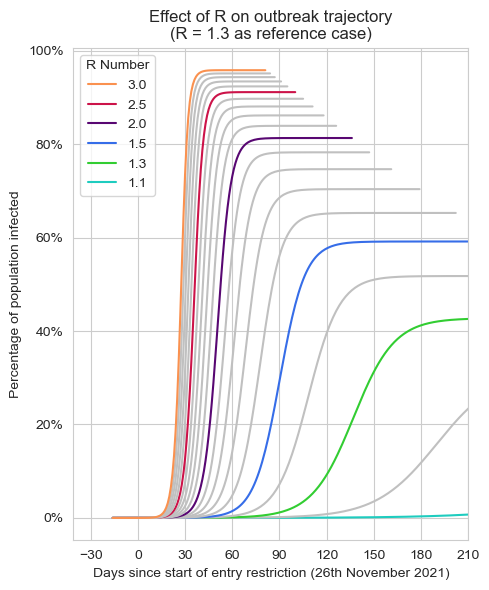

In [56]:
plot_data = d0_sens.loc[(d0_sens.u_NominalImports == 15) & (d0_sens.u_REff > 1.), :]
renamer = {'u_REff': 'R number',
           'cum_infected_pct': 'Percentage\ninfected',
           'elapsed_nominal': 'Days since reference date (26th Nov 2021)'}
plot_data = plot_data.rename(columns=renamer)

fig, ax4 = plt.subplots(figsize=(5, 6))
sns.lineplot(plot_data, x=renamer['elapsed_nominal'], y=renamer['cum_infected_pct'],
             hue=renamer['u_REff'], ax=ax4, palette=palette_s2)

ax4.set_xlim(None, 190)
ax4.set_xticks(range(-30, 211, 30))
ticks_y = ticker.FuncFormatter(lambda x, pos: f'{int(x * 100)}%')
ax4.yaxis.set_major_formatter(ticks_y)

ax4.set_xlabel('Days since start of entry restriction (26th November 2021)')
ax4.set_ylabel('Percentage of population infected')
ax4.set_title('Effect of R on outbreak trajectory\n'
              '(R = 1.3 as reference case)')
h, l = ax4.get_legend_handles_labels()
h = [h[k] for k, a in enumerate(l) if float(a) in s_R_highlight_all]
ax4.legend(handles=reversed(h), labels=reversed(s_R_highlight_all), title="R Number")

# ax4.legend(handles=reversed(h), labels=reversed(l),
#            title='R number')

plt.tight_layout()
fig.savefig(f'output_figures/plot_sens, R on outbreak trajectory, {model_vers}.jpg', dpi=300)

# Sensitivity: plot for import scaling on outbreak peak timing

In [57]:
d0_infc2 = results_s.pivot(values='infected_total', index='elapsed_nominal', columns='exp_id')
threshold = 50000  # 50k
d0_infc2_m = post.add_threshold_time_search(df_to_search=d0_infc2,
                                            df_to_add=meta_s,
                                            threshold=threshold)


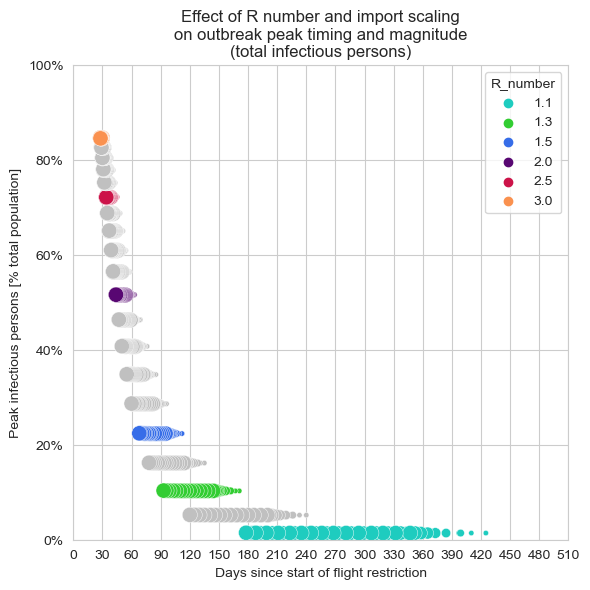

In [58]:
# plot peak sizes here
plot_data = d0_infc2_m.loc[d0_infc2_m['u_REff'] > 1.001, :]
plot_data = plot_data.rename(columns={'u_REff': 'R number',
                                      'u_NominalImports': 'Total Imports'})
plot_data['max'] = plot_data['max'] / exps_s.c_pop_total
scaling = 1
# plot_sizes = {5: scaling,  # in pt
#               10: 2 * scaling,
#               15: 3 * scaling,
#               20: 4 * scaling}

plot_sizes = {imp: scaling * imp for imp in plot_data['Total Imports'].unique()}
fig2, ax2 = plt.subplots(figsize=(6, 6))
plot2_peaks = sns.scatterplot(plot_data, x='max_day', y='max', hue='R number',
                              size='Total Imports', sizes=plot_sizes,
                              ax=ax2, palette=palette_s2)

ticks_y = ticker.FuncFormatter(lambda x, pos: f"{int(x * 100)}%")
ax2.set_ylim(0, 1)
ax2.yaxis.set_major_formatter(ticks_y)
ax2.set_xticks(ticks=(range(0, 511, 30)))
ax2.set_ylabel('Peak infectious persons [% total population]')
ax2.set_xlabel('Days since start of flight restriction')
ax2.set_title('Effect of R number and import scaling\n'
              'on outbreak peak timing and magnitude\n'
              '(total infectious persons)')

handles, labels = ax2.get_legend_handles_labels()
items = [1, 3, 5, 10, 15, 20]  # indices. hardcoded.
handles_plt, labels_plt = zip(*[(handles[idx], labels[idx]) for idx in items])
# labels_plt = [labels[idx] for idx in [0,2]]
ax2.legend(handles=handles_plt, labels=labels_plt, title='R_number')

plt.tight_layout()
fig2.savefig(f'output_figures/plot_sens_peak_timing, {model_vers}.jpg', dpi=300)
del fig2, ax2

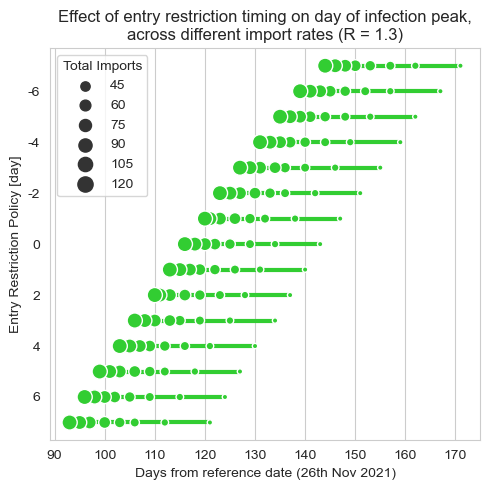

In [59]:

# specific plot for nominal case
plot_ref = 1.3
plot_data = d0_infc2_m.loc[d0_infc2_m['u_REff'] == plot_ref, :].copy()
plot_data['max'] = plot_data['max'] / exps_s.c_pop_total
rn = {'p_FlightBans': 'Entry Restriction Policy [day]',
      'u_NominalImports': 'Total Imports'}
plot_data = plot_data.rename(columns=rn)
fig3, ax3 = plt.subplots(figsize=(5, 5))
palette = 'cet_CET_R3'
# 'blueviolet' reference
palette_2 = dict((k, 'limegreen') for k in policy_inputs.values())
f3_line = sns.lineplot(plot_data, x='max_day', y=rn['p_FlightBans'],
                       hue=rn['p_FlightBans'], palette=palette_2, ax=ax3, legend=False, linewidth=3, zorder=0.9)
f3_scatter = sns.scatterplot(plot_data, x='max_day', y=rn['p_FlightBans'], hue=rn['p_FlightBans'],
                             size=rn['u_NominalImports'],
                             palette=palette_2,
                             ax=ax3, edgecolor='white', linewidth=1,
                             legend=True, sizes=plot_sizes)

ticks_y = ticker.FuncFormatter(lambda x, pos: f"{int(x - exps_s.c_nominal_ref_date)}")
ax3.yaxis.set_major_formatter(ticks_y)
ax3.invert_yaxis()
ax3.yaxis.grid(False)

# ax3.set_xticks(range(65, 101, 5))
ax3.set_xlabel('Days from reference date (26th Nov 2021)')

ax3.set_title('Effect of entry restriction timing '
              'on day of infection peak,\n'
              'across different import rates '
              f'(R = {plot_ref})')

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles=handles[-6:], labels=labels[-6:], title='Total Imports')

plt.tight_layout()
fig3.savefig(
    f'output_figures/plot_sens, effect of policy on infection peak, zoom nominal, {model_vers}, {plot_ref}.jpg',
    dpi=300)

del ax3, fig3

# Sensitivity: plot: deltas

In [60]:
# group by R0 and nominal import scaling, trying to get the difference in TDD (time delta difference).
# TDD describes the gain in days you get from having an earlier flight ban
infc2_m_group = d0_infc2_m.groupby(by=['u_REff', 'u_NominalImports'], axis=0, group_keys=True)
temp_dict = {}
metric = 'start_50000'

# isolate the start time of the outbreak
for i, cat in enumerate(infc2_m_group):
    name, group = cat
    t_early = group[metric].min()
    t_last = group[metric].max()
    t_range = t_last - t_early

    t_day_deltas = group[metric].diff(periods=-1)
    tdd_avg = t_day_deltas.mean()
    tdd_max = t_day_deltas.max()
    tdd_min = t_day_deltas.min()
    tdd_range = tdd_max - tdd_min

    temp_dict[i] = {
        'r0': name[0],
        'import': name[1],
        't_first': t_early,
        't_last': t_last,
        't_range': t_last - t_early,
        'tdd_max': tdd_max,
        'tdd_min': tdd_min,
        'tdd_avg': tdd_avg,
        'tdd_range': tdd_range,

    }

what_df = pd.DataFrame.from_dict(temp_dict, orient='index')
del temp_dict, metric, i, cat, name, group, t_early, t_last, t_range, t_day_deltas, tdd_min, tdd_max, tdd_avg, tdd_range

Text(0.5, 0, 'Days since nominal')

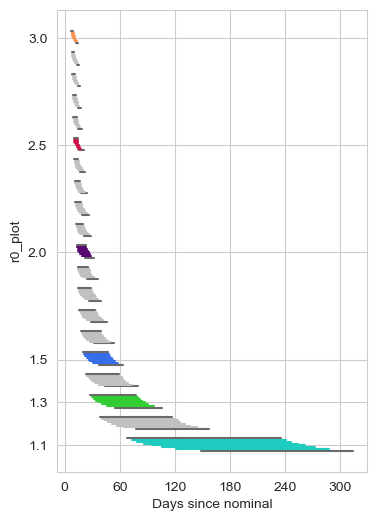

In [61]:
# we know that the t_range, tdd_avg, and tdd_range are the same across R0
# the effect of importation is seen to only affect peak timing
# however, the efficacy of the flight bans over longer durations is not visible, due to the short range of flight bans
# how about difference of period between
what_df['r0_plot'] = what_df.r0 + ((what_df['import'] // 15 - 4) / 120)
what_df['category'] = [str(i) for i in list(zip(what_df['r0'], what_df['import']))]

# massage common palette for plotting
wdf_color_diff = list(zip(what_df['r0'], what_df['import'], what_df['category']))
# create redundant palette
wdf_palette = {}
wdf_makeblack = [15, 120]
for r0, imp, cat in wdf_color_diff:
    if imp in wdf_makeblack:
        wdf_palette[cat] = 'dimgray'
    else:
        wdf_palette[cat] = palette_s2[r0]

what_df_melt = what_df.melt(id_vars=['r0_plot', 'r0', 'import', 'category'], value_vars=['t_first', 't_last'])
fig, ax = plt.subplots(figsize=(4, 6))
sns.lineplot(data=what_df_melt, x='value', y='r0_plot', hue='category', palette=wdf_palette, ax=ax, legend=False)

ax.set_yticks(s_R_highlight_all)
ax.set_xticks(range(0, 301, 60))
ax.set_xlabel('Days since nominal')

In [62]:
# make heatmap (due to large disparity in t_range)
# we isolate for 5 scenarios: 1.1, 1.5, 2.0, 2.5, 3.0
# look at t_range and tdd
# r_range = [1.1, 1.5, 2., 2.5, 3.]
# what_df_specific = what_df[what_df['r0'].isin(r_range)]
# try plotting the TDDs

# create redundant palette
wdf_palette = {}
wdf_makeblack = []
for r0, imp, cat in wdf_color_diff:
    if imp in wdf_makeblack:
        wdf_palette[cat] = 'dimgray'
    else:
        wdf_palette[cat] = palette_s2[r0]


In [63]:
# clean up data for histogram/heatmap
# we choose [15, 60, 120]
# try to reference from nominal day
# we want

ddelta_scenarios = [15, 60, 120]
ddelta_df = d0_infc2_m[d0_infc2_m['u_NominalImports'].isin(ddelta_scenarios)].drop(
    columns=['p_FlightBans', 'u_TIncub', 'c_SimTime', 'c_PopTotal', 'c_model_engine'])
ddelta_df['t_start_to_max'] = ddelta_df['max_day'] - ddelta_df['start_50000']


In [73]:
# get relative day difference and day delta from nominal?
# separate according to scenario

dd_df2 = d0_infc2_m.groupby(by=['u_REff', 'u_NominalImports'], group_keys=True)
temp_dict = {}
temp_dict_rel = {}
# get difference vs next import state
# we know that the t_range stays almost constant

metric = 'start_50000'
for i, cat in enumerate(dd_df2):
    name, group = cat
    # get relative difference from nominal date
    t_early = group[metric].max()
    t_late = group[metric].min()
    t_nom = group[group['p_FlightBans_nom'] == 0][metric].item()
    td_early = t_early - t_nom
    td_late = t_late - t_nom
    td_range = t_early - t_late

    # get relative policy gain
    td_rel = group.set_index('p_FlightBans_nom')[metric].diff(periods=-1)
    td_rel_range = td_rel.max() - td_rel.min()
    td_rel_avg = td_rel.mean()
    td_rel_med = td_rel.median()

    temp_dict[i] = {
        'r0': name[0],
        'import': name[1],
        't_early': t_early,
        't_nominal': t_nom,
        't_late': t_late,
        'td_early': td_early,
        'td_late': td_late,
        'td_range': td_range,
        'td_rel_range': td_rel_range,
        'td_rel_avg': td_rel_avg,
        'td_rel_med': td_rel_med
    }
    temp_dict_rel[name] = td_rel

dd_df2_stats = pd.DataFrame.from_dict(temp_dict, orient='index')
dd_td_stats = pd.concat(temp_dict_rel, axis=1)

# fig, ax = plt.subplots(figsize=(6,6))
# sns.scatterplot(what_df, x='tdd_avg',
#                 y='r0',
#                 hue='category',
#                 palette=wdf_palette,
#                 legend=False,
#                 linewidths=0.,
#                 alpha=0.5,
#                 ax=ax)
# ax.set_yticks(s_R_highlight_all)
# ax.set_xticks(range())


In [0]:
# first isolate for t_nominal
# what do I want to show? -> how lower R values lead to more effective flight bans
# non-linear relationship
# get dfs and save into excels?
dd_df3 = dd_df2_stats[dd_df2_stats['import'].isin(ddelta_scenarios)].sort_values(by=['import', 'r0'])


In [79]:
dd_df3.to_csv('output_figures/dd_df_scenarios.csv', sep=',', index=False)